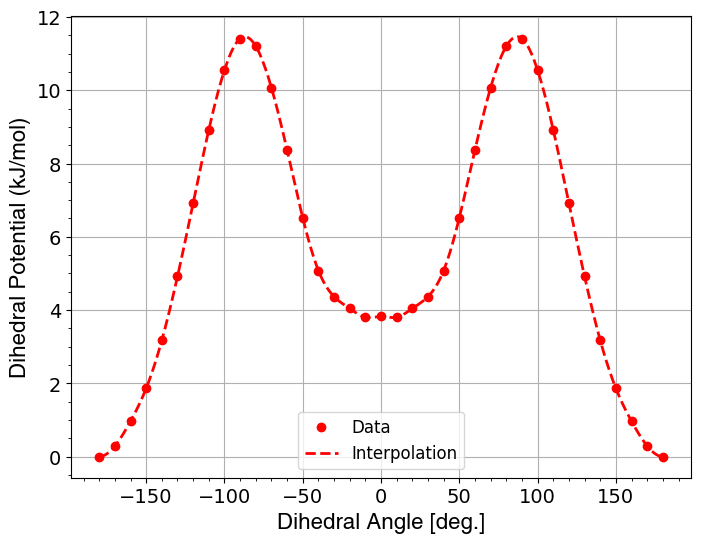

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import scipy.constants as sc
from joblib import Parallel, delayed
import psutil

P3HTDihedral_list = [[0, 0], [10, 0.293835], [20, 0.967939], [30, 1.86645],
                     [40, 3.177], [50, 4.91823], [60, 6.91593], [70, 8.91844],
                     [80, 10.5465], [90, 11.4081], [100, 11.2003],
                     [110, 10.0682], [120, 8.36782], [130, 6.51926],
                     [140, 5.079767], [150, 4.36963], [160, 4.04486],
                     [170, 3.80474], [180, 3.82803]]
P3HTDihedral = np.array(P3HTDihedral_list)
# using a common method, the 0 degree conformation is the cis conformation, so we shall subtract 180 degrees from all angles
P3HTDihedral[:, 0] -= 180
new = P3HTDihedral.copy()
new[:, 0] = -new[:, 0]
P3HTDihedral_combined = np.concatenate((P3HTDihedral, new))
P3HTDihedral = np.unique(P3HTDihedral_combined, axis=0)

fitf = interp1d(P3HTDihedral[:, 0],
                P3HTDihedral[:, 1],
                kind='cubic',
                fill_value="extrapolate")

# In[190]:= Show[ListPlot[...],Plot[...]]
plt.figure(figsize=(8, 6))
plt.plot(P3HTDihedral[:, 0], P3HTDihedral[:, 1], 'ro', label='Data')
x_fit = np.linspace(-180, 180, 361)
plt.plot(x_fit, fitf(x_fit), 'r--', linewidth=2, label='Interpolation')
plt.xlabel("Dihedral Angle [deg.]", fontsize=16, fontname="Helvetica")
plt.ylabel("Dihedral Potential (kJ/mol)", fontsize=16, fontname="Helvetica")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.minorticks_on()
plt.show()

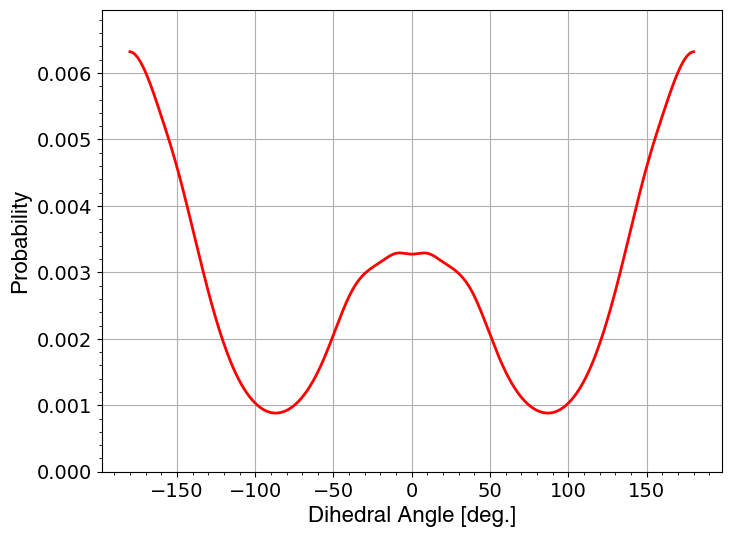

In [2]:

temperature = 700
kTval = temperature * sc.R / 1000 # kJ/mol

normVal, _ = quad(lambda x: np.exp(-fitf(x) / kTval), 0, 180)
normVal *= 2

def prob(x):
    return np.exp(-fitf(x) / kTval) / normVal

x_prob = np.linspace(-180, 180, 1000)
y_prob = [prob(xi) for xi in x_prob]
plt.figure(figsize=(8, 6))
plt.plot(x_prob, y_prob, 'r-', linewidth=2)
plt.xlabel("Dihedral Angle [deg.]", fontsize=16, fontname="Helvetica")
plt.ylabel("Probability", fontsize=16, fontname="Helvetica")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, np.max(y_prob) * 1.1)
plt.grid(True)
plt.minorticks_on()
plt.show()

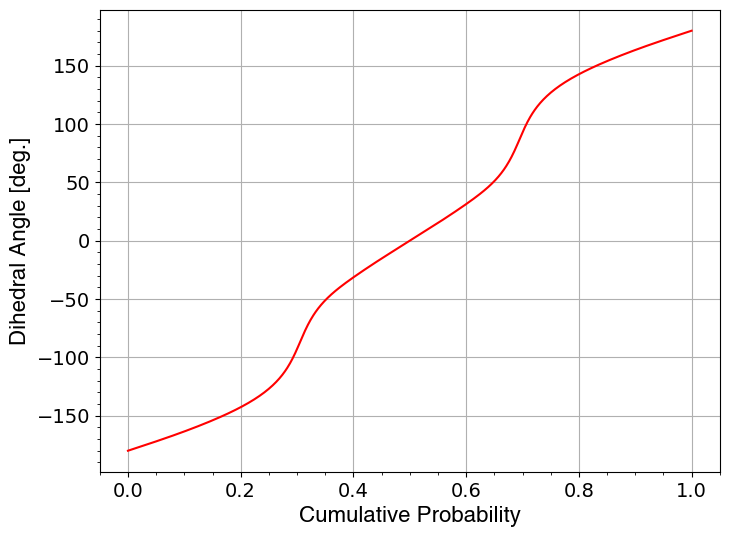

In [ ]:
# In[197]:= pIntTable = Quiet[Table[{NIntegrate[prob[xp],{xp,0,x}],x},{x,0,360}]];
pIntTable = []
for x in np.linspace(-180, 180, 361):
    cumulative_prob, _ = quad(prob, -180, x)
    pIntTable.append([cumulative_prob, x])
pIntTable = np.array(pIntTable)

# In[199]:= th[prob_]=Interpolation[pIntTable][prob];
th = interp1d(pIntTable[:, 0],
                     pIntTable[:, 1],
                     kind='cubic',
                     fill_value="extrapolate")

# ListPlot[pIntTable, PlotStyle->{PointSize,Red},Frame->True,Axes->False,FrameLabel->{"Cumulative Probability","Dihedral Angle [deg.]"},FrameTicks->Automatic,LabelStyle->Directive[Black,FontFamily->"Helvetica",16]]
plt.figure(figsize=(8, 6))
plt.plot(pIntTable[:, 0], pIntTable[:, 1], 'r-', markersize=4)
plt.xlabel("Cumulative Probability", fontsize=16, fontname="Helvetica")
plt.ylabel("Dihedral Angle [deg.]", fontsize=16, fontname="Helvetica")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.minorticks_on()
plt.show()

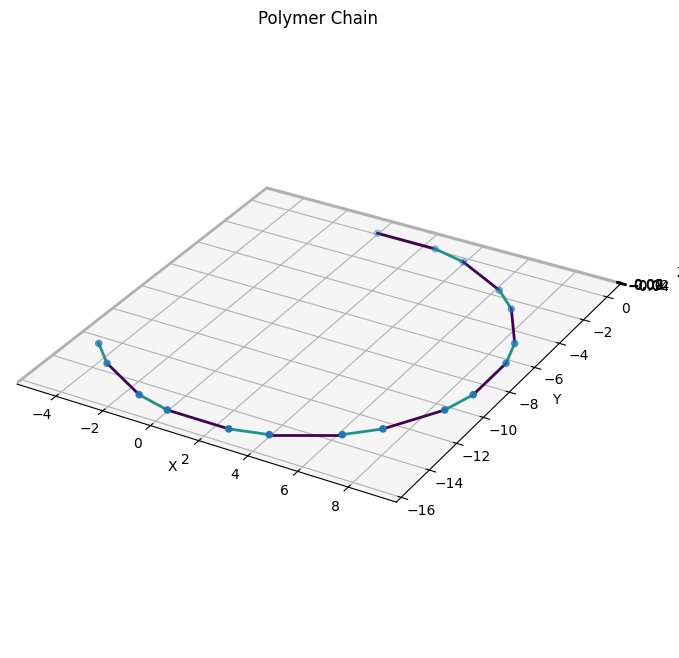

In [4]:
# lcsc=2.548;
# lcc=1.480;
# e[1]=lcsc{0,0,1};
# e[2]=lcc {Sin[Pi / 12.],0,Cos[Pi / 12.]};
# e[3]=lcsc {0,0,1};
# e[4]=lcc {Sin[-Pi / 12.],0,Cos[Pi / 12.]};
lcsc, lcc =2.548,1.480
angle1, angle2 = -15 * np.pi / 180, -15 * np.pi / 180
l = [lcsc, lcc]
Angle = np.array([angle1, angle2])
length = len(l)
l_array = np.vstack((np.array([l]), np.zeros((2, length)))).T

def rotation_matrix(axis, angle):
    """
    Return the rotation matrix associated with 
    counterclockwise rotation about the given 
    axis by angle radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# l_array[1] rotated by angle[0]
def chain(n):
    angles = np.cumsum(Angle[np.arange(n-1) % length])
    vectors = l_array[np.arange(1, n) % length]  # shape (n-1, 3)
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2] 
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))    
    return np.cumsum(np.vstack((np.array([[0, 0, 0], l_array[0]]), segments)),
                     axis=0)

def drawChain(pts):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0], pts_array[:, 1], pts_array[:, 2], s=20)
    for i in range(len(pts) - 1):
        ax.plot([pts[i][0], pts[i + 1][0]], [pts[i][1], pts[i + 1][1]],
                [pts[i][2], pts[i + 1][2]],
                color=plt.get_cmap('viridis')(i % length * (256 // length)),
                linewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()

drawChain(chain(8*length))

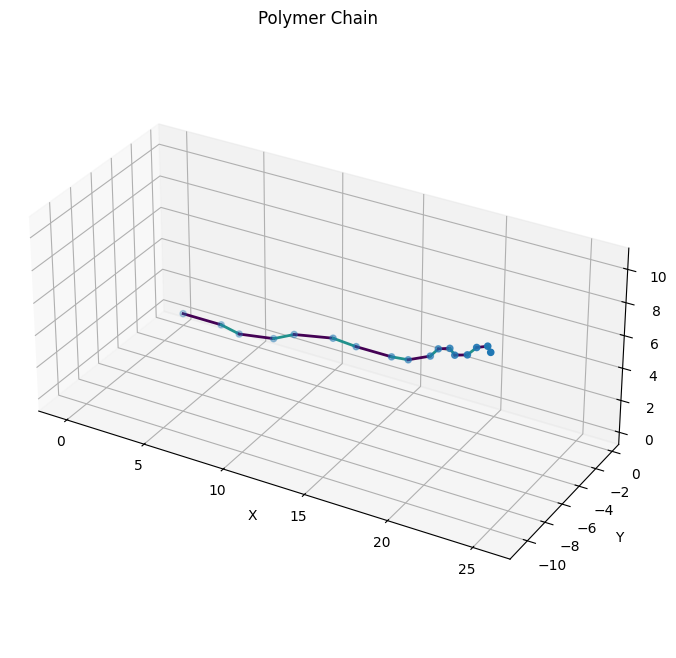

In [5]:
def dihedralRotate(pts, nb, theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    vec = pts[nb] - pts[nb - 1]
    vec_norm = np.linalg.norm(vec)
    axis = vec / vec_norm
    rot = rotation_matrix(axis, theta_rad)
    pts[nb + 1:] = (pts[nb+1:] - pts[nb]) @ rot.T + pts[nb]
    return pts

def randomRotate(pts):
    newpts = pts.copy()
    k_values = np.arange(2, len(pts)-1, 2)
    mod_k = k_values % length
    mask_a = np.isin(mod_k, [0])     # th
    rand_a = th(np.random.rand(mask_a.sum()))
    for k, angle in zip(k_values[mask_a], rand_a):
        dihedralRotate(newpts, k, angle)
    return newpts

drawChain(randomRotate(chain(8*length)))

In [6]:
def cosVals(pts):
    k_values = np.arange(2, len(pts), length)
    vectors = pts[k_values] - pts[k_values-1]
    v2 = vectors[0]
    dots = vectors @ v2
    norms = np.linalg.norm(vectors, axis=1) * np.linalg.norm(v2)
    return np.clip(dots/norms, -1, 1)

# Correlation function calculation
n_repeat_units = 20
chain_length = n_repeat_units * length
ch = chain(chain_length)
n_samples = 50000

def calculate_cos_vals(i):
    return cosVals(randomRotate(ch))

import psutil
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
n_jobs = psutil.cpu_count(logical=False)
cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_vals)(i) for i in range(n_samples))
corr2 = np.mean(np.array(cosList2), axis=0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 14336 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    5.9s finished


logFitPrime (slope): -0.09631916028595143
Correlation length: 10.382150311850822


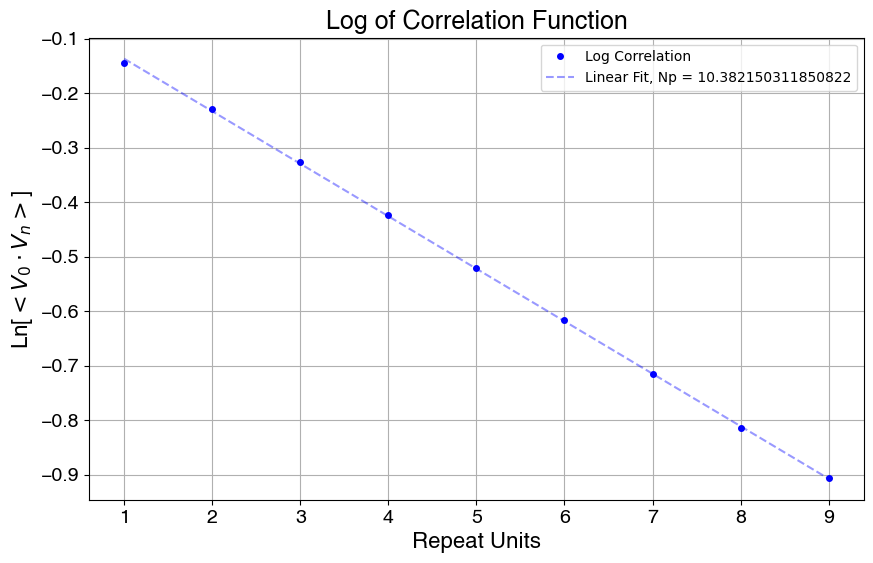

In [7]:
repeat_units = np.arange(len(corr2))


def linear_func(x, a, b):
    return a + b * x


start_idx = 1
end_idx = 10
popt, pcov = curve_fit(linear_func, repeat_units[start_idx:end_idx], np.log(corr2[start_idx:end_idx]))
logFit_prime = popt[1]
persistence_length = -1 / logFit_prime
print(f"logFitPrime (slope): {logFit_prime}")
print(f"Correlation length: {persistence_length}")

plt.figure(figsize=(10, 6))
plt.plot(repeat_units[start_idx:end_idx],
         np.log(corr2[start_idx:end_idx]),
         'bo',
         markersize=4,
         label='Log Correlation')
plt.plot(repeat_units[start_idx:end_idx],
         linear_func(repeat_units[start_idx:end_idx], *popt),
         'b--', alpha=0.4,
         label=f'Linear Fit, Np = {persistence_length}')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True)
plt.legend()
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.show()

In [8]:
# In[218]:= (*Here we compute the mean-equare end-to-end distance for P3HT with degree of polymerization varying
# from 1 to 25.*)
# R2:=Module[{ch0,ree,ch,reelist},reelist=Table[{i,{}},{i,1,25}];Do[ch0=chain[i*2];ree = ParallelTable[ch=randomRotate[ch0];Norm[Last[ch]-First[ch]],{10000}];reelist[[i,2]]=0.01Mean[ree^2],{i,1,25}];reelist]
def R2_calculation():
    reelist = []
    num_polymers = 25
    num_rotations_r2 = 10000

    # 定义处理单个聚合度的函数
    def process_polymer(i):
        ch0 = chain(i * 2)
        
        # 定义计算单个ree_squared的函数
        def compute_ree_squared(_):
            ch = randomRotate(ch0)
            end_to_end_vector = ch[-1] - ch[0]
            return np.linalg.norm(end_to_end_vector)**2
        # 并行计算所有ree_squared
        ree_squared_list = Parallel(n_jobs=n_jobs, verbose=1)(
            delayed(compute_ree_squared)(_) for _ in range(num_rotations_r2)
        )
        return [i, 0.01 * np.mean(ree_squared_list)]

    # 并行处理所有聚合度
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(process_polymer)(i) for i in range(1, num_polymers + 1)
    )
    
    # 按聚合度排序结果
    return sorted(results, key=lambda x: x[0])

# 计算 R2List
R2List = R2_calculation()

# 将 R2List 转换为 NumPy 数组
R2List = np.array(R2List)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   27.1s finished


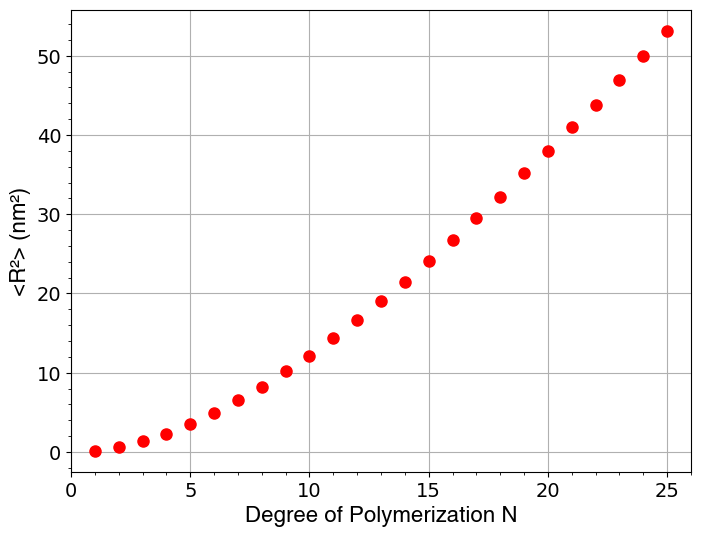

In [9]:
# ListPlot[R2List,PlotMarkers->Automatic,PlotStyle->{Red},Frame->True,PlotRange->All,FrameLabel->{"Degree of Polyemrization N","<R^2> (nm^2)"},FrameTicks->Automatic,LabelStyle->Directive[Black,FontFamily->"Helvetica", 16]]
plt.figure(figsize=(8, 6))
plt.plot(R2List[:, 0], R2List[:, 1], 'ro', markersize=8)
plt.xlabel("Degree of Polymerization N", fontsize=16, fontname="Helvetica")
plt.ylabel("<R²> (nm²)", fontsize=16, fontname="Helvetica")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 26)
plt.grid(True)
plt.minorticks_on()
plt.show()